# Kaggle Bike Sharing Demand(レンタサイクルの需要予測)

## データの確認

In [1439]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # グラフ描画用
import seaborn as sns; sns.set() # グラフ描画用

In [1440]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
df = pd.concat([train, test])
submission = pd.read_csv('input/sampleSubmission.csv')
# df.to_csv('output/df.csv',index=False)

In [1441]:
test_datetime = pd.DataFrame(test['datetime'])
test_datetime.head()

,datetime
0,2011-01-20 00:00:00
1,2011-01-20 01:00:00
2,2011-01-20 02:00:00
3,2011-01-20 03:00:00
4,2011-01-20 04:00:00


In [1442]:
display(train.shape)
display(test.shape)
display(df.shape)
print('test:' + str(round(test.shape[0]/df.shape[0]*100,1)) + '%')

(10886, 12)

(6493, 9)

(17379, 12)

test:37.4%


In [1443]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [1444]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [1445]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [1446]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,10886.000000,10886.000000
mean,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,36.021955,155.552177,191.574132
std,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,17.000000,118.000000,145.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000


In [1447]:
# season = 4
# display(((train["weather"].values == 1) & (train["season"].values == season)).sum() / (train["season"].values == season).sum()*100)
# display(((train["weather"].values == 2) & (train["season"].values == season)).sum() / (train["season"].values == season).sum()*100)
# display(((train["weather"].values == 3) & (train["season"].values == season)).sum() / (train["season"].values == season).sum()*100)
# display(((train["weather"].values == 4) & (train["season"].values == season)).sum() / (train["season"].values == season).sum()*100)
# season = 3
# train.loc[(train["season"].values == season)]['temp'].min()

## データの加工

やること
- 日付から年、月、日、時間の列を生成 ok
- season番号の振り直し ok
- weekend列の作成 ok
- 新規利用者比率
- 降水量の推定. weatherとhumidityで特徴量作れるか
- キャンペーン日の特定(月初めの決まった曜日？)

In [1448]:
df['year'] = pd.to_datetime(df['datetime']).dt.strftime('%Y')
df['month'] = pd.to_datetime(df['datetime']).dt.strftime('%m')
df['day'] = pd.to_datetime(df['datetime']).dt.strftime('%d')
df['weekday'] = pd.to_datetime(df['datetime']).dt.strftime('%a')
df['hour'] = pd.to_datetime(df['datetime']).dt.strftime('%H')

In [1449]:
df['weekend'] = 0
df.loc[(df['holiday'].values==0) & (df['workingday'].values==0),'weekend'] = 1

In [1450]:
df['day_type'] = 'holiday'
df.loc[(df['workingday'].values==1), 'day_type'] = 'workingday'
df.loc[(df['weekend'].values==1), 'day_type'] = 'weekend'

In [1451]:
df['month'] = df['month'].astype('int')
spring_begin = 3
summer_begin = 6
fall_begin = 9
df['season_rev'] = 4 #12,1,2月は面倒なので先に代入
df.loc[(df['month'].values >= spring_begin) & (df['month'].values < (spring_begin+3)),'season_rev'] = 1
df.loc[(df['month'].values >= summer_begin) & (df['month'].values < (summer_begin+3)),'season_rev'] = 2
df.loc[(df['month'].values >= fall_begin  ) & (df['month'].values < (fall_begin+3  )),'season_rev'] = 3
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour,weekend,day_type,season_rev
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011,1,01,Sat,00,1,weekend,4
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011,1,01,Sat,01,1,weekend,4
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011,1,01,Sat,02,1,weekend,4
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011,1,01,Sat,03,1,weekend,4
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011,1,01,Sat,04,1,weekend,4


In [1452]:
df['casual_ratio'] = df['casual']/df['count']*100

In [1453]:
df = df[['datetime', 'year', 'month', 'day', 'weekday', 'hour', 'season', 'season_rev',
         'day_type', 'holiday', 'workingday', 'weekend',
         'weather', 'temp','atemp', 'humidity', 'windspeed',
         'casual', 'registered', 'count', 'casual_ratio'
       ]]
df.head()

,datetime,year,month,day,weekday,hour,season,season_rev,day_type,holiday,...,weekend,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_ratio
0,2011-01-01 00:00:00,2011,1,01,Sat,00,1,4,weekend,0,...,1,1,9.84,14.395,81,0.0,3.0,13.0,16.0,18.750000
1,2011-01-01 01:00:00,2011,1,01,Sat,01,1,4,weekend,0,...,1,1,9.02,13.635,80,0.0,8.0,32.0,40.0,20.000000
2,2011-01-01 02:00:00,2011,1,01,Sat,02,1,4,weekend,0,...,1,1,9.02,13.635,80,0.0,5.0,27.0,32.0,15.625000
3,2011-01-01 03:00:00,2011,1,01,Sat,03,1,4,weekend,0,...,1,1,9.84,14.395,75,0.0,3.0,10.0,13.0,23.076923
4,2011-01-01 04:00:00,2011,1,01,Sat,04,1,4,weekend,0,...,1,1,9.84,14.395,75,0.0,0.0,1.0,1.0,0.000000


In [1454]:
# day_count = train.pivot_table(index='day_type', columns=['day'], aggfunc='size', fill_value=0)
# display(day_count)
# campaign = train.loc[(train['casual_ratio'].values >= 50)].pivot_table(index='day_type', columns=['day'], aggfunc='size', fill_value=0)
# display(campaign)
# # 4月,7月,9月の特定日に新規利用者比率の外れ値が見られる

## データの前処理
時系列データをint型に変更
day_typeをLabelEncoderで数値に変換

In [1455]:
from sklearn.preprocessing import LabelEncoder

In [1456]:
df['year'] = df['year'].astype('int')
df['day'] = df['day'].astype('int')
df['hour'] = df['hour'].astype('int')

In [1457]:
le = LabelEncoder()
le.fit(df['weekday'])
df['weekday'] = le.transform(df['weekday'])
le.fit(df['day_type'])
df['day_type'] = le.transform(df['day_type'])

In [1466]:
# casualとregisteredを対数変換
# 0を含むため全データに1を足してから対数変換
# 予測値を変換した後に1を引く
# count_min = 1
# casual_max = df['casual'].max()
# registered_max = df['registered'].max()
# display(df.loc[df['casual'].values > 0, 'casual'].min())

def log_transform(trg):
    df[trg] = df[trg]/(df[trg].max()) #0~1になる
    count_min = df.loc[df['casual'].values > 0, 'casual'].min()
    df[trg] = df[trg] + count_min
    display(df.head())
    

log_transform('casual')
# log_transform('registered')

,datetime,year,month,day,weekday,hour,season,season_rev,day_type,holiday,...,weekend,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_ratio
0,2011-01-01 00:00:00,2011,1,1,2,0,1,4,1,0,...,1,1,9.84,14.395,81,0.0,0.013587,13.0,16.0,18.750000
1,2011-01-01 01:00:00,2011,1,1,2,1,1,4,1,0,...,1,1,9.02,13.635,80,0.0,0.027174,32.0,40.0,20.000000
2,2011-01-01 02:00:00,2011,1,1,2,2,1,4,1,0,...,1,1,9.02,13.635,80,0.0,0.019022,27.0,32.0,15.625000
3,2011-01-01 03:00:00,2011,1,1,2,3,1,4,1,0,...,1,1,9.84,14.395,75,0.0,0.013587,10.0,13.0,23.076923
4,2011-01-01 04:00:00,2011,1,1,2,4,1,4,1,0,...,1,1,9.84,14.395,75,0.0,0.005435,1.0,1.0,0.000000


In [1426]:
df.head()
df.describe()

,year,month,day,weekday,hour,season,season_rev,day_type,holiday,workingday,weekend,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_ratio
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011.502561,6.537775,15.683411,2.992577,11.546752,2.501640,2.485241,1.653950,0.028770,0.682721,0.288509,1.425283,20.376474,23.788755,62.722884,12.736540,2.712439,4.395774,191.574132,17.100841
std,0.500008,3.438776,8.789373,1.997928,6.914405,1.106918,1.115985,0.532782,0.167165,0.465431,0.453082,0.639357,7.894801,8.592511,19.292983,8.196795,1.491055,1.399383,181.144454,13.692361
min,2011.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2011.000000,4.000000,8.000000,1.000000,6.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,1.609438,3.610918,42.000000,6.168831
50%,2012.000000,7.000000,16.000000,3.000000,12.000000,3.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,20.500000,24.240000,63.000000,12.998000,2.890372,4.779123,145.000000,14.473684
75%,2012.000000,10.000000,23.000000,5.000000,18.000000,3.000000,3.000000,2.000000,0.000000,1.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,3.912023,5.407172,284.000000,25.342466
max,2012.000000,12.000000,31.000000,6.000000,23.000000,4.000000,4.000000,2.000000,1.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,5.908083,6.787845,977.000000,100.000000


In [1427]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 6492
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datetime      17379 non-null  object 
 1   year          17379 non-null  int64  
 2   month         17379 non-null  int64  
 3   day           17379 non-null  int64  
 4   weekday       17379 non-null  int64  
 5   hour          17379 non-null  int64  
 6   season        17379 non-null  int64  
 7   season_rev    17379 non-null  int64  
 8   day_type      17379 non-null  int64  
 9   holiday       17379 non-null  int64  
 10  workingday    17379 non-null  int64  
 11  weekend       17379 non-null  int64  
 12  weather       17379 non-null  int64  
 13  temp          17379 non-null  float64
 14  atemp         17379 non-null  float64
 15  humidity      17379 non-null  int64  
 16  windspeed     17379 non-null  float64
 17  casual        10886 non-null  float64
 18  registered    10886 non-nul

## 機械学習
trainデータを分割してcasualとregisteredを目的変数に設定

In [1428]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
from sklearn.metrics import r2_score # モデル評価用(決定係数)

In [1429]:
df = df[[
    # 'datetime', 
    'year', 
    'month', 
    # 'day', train:1-19,test:20-
    'weekday', 
    'hour', 
    # 'season',       
    # 'season_rev', 
    'day_type', 
    # 'holiday', 
    # 'workingday', 
    # 'weekend', 
    'weather',
    'temp',
    # 'atemp',
    'humidity',
    'windspeed',
    'casual',
    'registered',
    # 'count',
    # 'casual_ratio',
    ]]
df.head()

,year,month,weekday,hour,day_type,weather,temp,humidity,windspeed,casual,registered
0,2011,1,2,0,1,1,9.84,81,0.0,1.386294,2.639057
1,2011,1,2,1,1,1,9.02,80,0.0,2.197225,3.496508
2,2011,1,2,2,1,1,9.02,80,0.0,1.791759,3.332205
3,2011,1,2,3,1,1,9.84,75,0.0,1.386294,2.397895
4,2011,1,2,4,1,1,9.84,75,0.0,0.000000,0.693147


In [1430]:
train = df.iloc[:len(train),:].copy()
test  = df.iloc[len(train):,:].copy()
test.drop(['casual','registered'], axis=1, inplace=True)
display(train.head())
display(test.head())

,year,month,weekday,hour,day_type,weather,temp,humidity,windspeed,casual,registered
0,2011,1,2,0,1,1,9.84,81,0.0,1.386294,2.639057
1,2011,1,2,1,1,1,9.02,80,0.0,2.197225,3.496508
2,2011,1,2,2,1,1,9.02,80,0.0,1.791759,3.332205
3,2011,1,2,3,1,1,9.84,75,0.0,1.386294,2.397895
4,2011,1,2,4,1,1,9.84,75,0.0,0.000000,0.693147


,year,month,weekday,hour,day_type,weather,temp,humidity,windspeed
0,2011,1,4,0,2,1,10.66,56,26.0027
1,2011,1,4,1,2,1,10.66,56,0.0000
2,2011,1,4,2,2,1,10.66,56,0.0000
3,2011,1,4,3,2,1,10.66,56,11.0014
4,2011,1,4,4,2,1,10.66,56,11.0014


### casualを学習

In [1431]:
def machine_learning(trg):
    X = train.drop(['casual','registered'], axis=1)
    y = train[trg]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=0)
    
    # ---------- 
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) 

    # LightGBM parameters
    params = {
            'task': 'predict',
            'boosting_type': 'gbdt',
            'objective': 'regression', # 目的 : 回帰  
            'metric': {'rmse'}, # 評価指標 : rsme(平均二乗誤差の平方根) 
            'learning_rate': 0.1,
            'num_leaves': 23,
            'min_data_in_leaf': 1,
            'num_trees': 100, #1000回学習
            'verbose': 0
    }

    # モデルの学習
    model = lgb.train(params, # パラメータ
                categorical_feature=[
                    'year',
                    'month',
                    'weekday',
                    # 'hour',
                    'day_type',
                    'weather',
                    # '',
                    # '',
                    # '',
                ],
                train_set=lgb_train, # トレーニングデータの指定
                valid_sets=lgb_eval, # 検証データの指定
                early_stopping_rounds=100 # 100回ごとに検証精度の改善を検討　→ 精度が改善しないなら学習を終了(過学習に陥るのを防ぐ)
                   )

    # テストデータの予測
    y_pred = model.predict(X_test)
    
    # 真値と予測値の表示
    df_pred = pd.DataFrame({'train':y_test,'train_pred':y_pred})
    display(df_pred)

    # 散布図を描画(真値 vs 予測値)
    plt.plot(y_test, y_test, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
    plt.scatter(y_test, y_pred) # 散布図のプロット
    plt.xlabel('y') # x軸ラベル
    plt.ylabel('y_test') # y軸ラベル
    plt.title('y vs y_pred') # グラフタイトル
    plt.show()
    
    # ---------- 

    # モデル評価
    # rmse : 平均二乗誤差の平方根
    mse = mean_squared_error(y_test, y_pred) # MSE(平均二乗誤差)の算出
    rmse = np.sqrt(mse) # RSME = √MSEの算出
    print('RMSE :',rmse)

    # r2 : 決定係数
    r2 = r2_score(y_test,y_pred)
    print('R2 :',r2)
    
    test_pred = model.predict(test)
    # test_pred = model.predict(test, num_iteration=model.best_iteration_)
    test_pred = pd.DataFrame(test_pred,  columns=[trg])
    # display(submission.head(24))
    return test_pred

In [1432]:
# def inv_transform(trg, count_min):
#     count = machine_learning(trg)[trg]
#     count = np.exp(count) - count_min
#     return count

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's rmse: 1.37871
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 1.27472
[3]	valid_0's rmse: 1.1834
[4]	valid_0's rmse: 1.10259
[5]	valid_0's rmse: 1.03174
[6]	valid_0's rmse: 0.968652
[7]	valid_0's rmse: 0.912306
[8]	valid_0's rmse: 0.863445
[9]	valid_0's rmse: 0.820932
[10]	valid_0's rmse: 0.782285
[11]	valid_0's rmse: 0.748377
[12]	valid_0's rmse: 0.718568
[13]	valid_0's rmse: 0.691947
[14]	valid_0's rmse: 0.669344
[15]	valid_0's rmse: 0.648384
[16]	valid_0's rmse: 0.631003
[17]	valid_0's rmse: 0.614663
[18]	valid_0's rmse: 0.60015
[19]	valid_0's rmse: 0.587751
[20]	valid_0's rmse: 0.5762
[21]	valid_0's rmse: 0.56649
[22]	valid_0's rmse: 0.5

/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day_type', 'month', 'weather', 'weekday', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/s

,train,train_pred
6638,3.806662,3.363197
7975,3.433987,3.366635
5915,2.944439,2.952004
8050,4.595120,4.586108
5894,3.044522,3.150126
...,...,...
1277,1.609438,0.933222
2587,4.430817,4.085070
7950,4.290459,4.423076
9878,2.302585,2.770040


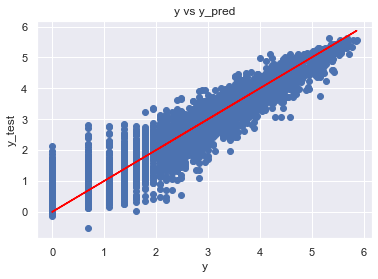

RMSE : 0.4759444491410515
R2 : 0.8987072846552042
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's rmse: 1.28355
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 1.18344
[3]	valid_0's rmse: 1.09583
[4]	valid_0's rmse: 1.01845
[5]	valid_0's rmse: 0.948836
[6]	valid_0's rmse: 0.88906
[7]	valid_0's rmse: 0.833381
[8]	valid_0's rmse: 0.785724
[9]	valid_0's rmse: 0.744038
[10]	valid_0's rmse: 0.704364
[11]	valid_0's rmse: 0.672619
[12]	valid_0's rmse: 0.641878
[13]	valid_0's rmse: 0.612495
[14]	valid_0's rmse: 0.587366
[15]	valid_0's rmse: 0.565235
[16]	valid_0's rmse: 0.541687
[17]	valid_0's rmse: 0.524385
[18]	valid_0's rmse: 0.501525
[19]	valid_0's rmse: 0.483931
[20]	valid_0's rmse: 0.470148

/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day_type', 'month', 'weather', 'weekday', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/s

,train,train_pred
6638,5.303305,5.296702
7975,5.347108,5.497303
5915,5.356586,5.461207
8050,5.913503,6.156468
5894,5.755742,5.848618
...,...,...
1277,2.564949,2.174651
2587,6.320768,6.153069
7950,5.236442,5.336135
9878,4.290459,4.497661


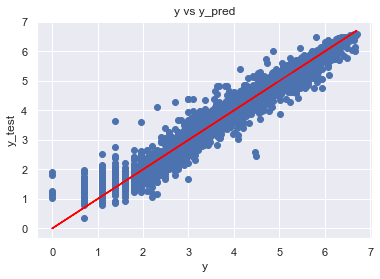

RMSE : 0.29586080726812225
R2 : 0.9548949260472714


In [1433]:
# submission['count'] = inv_transform('casual', count_min) + inv_transform('registered', count_min)
# submission['count'] = round(submission['count'],0).astype('int')

In [1434]:
# submission.describe()

,count
count,6493.000000
mean,181.148006
std,166.858321
min,1.000000
25%,42.000000
50%,140.000000
75%,270.000000
max,828.000000


In [1436]:
# submission.to_csv('output/submission.csv',index=False)